# Classifying the visibility of ID cards in photos.

In [73]:
import pandas as pd
import os
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
import logging

## Data Exploration : Explore/ Preprocess the .csv

In [2]:
imagedf = pd.read_csv('D:/aalink/gicsd_labels.csv')
imagedf.head()

,IMAGE_FILENAME,LABEL
0,GICSD_1_0_3.png,FULL_VISIBILITY
1,GICSD_1_0_13.png,FULL_VISIBILITY
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY
3,GICSD_1_1_53.png,FULL_VISIBILITY
4,GICSD_1_2_73.png,FULL_VISIBILITY


### Summary : First, second and third class
Before looking into the images themselves, it's interesting to see what's the distribution of the labels in the dataset.

In [3]:
imagedf.dtypes

IMAGE_FILENAME    object
 LABEL            object
dtype: object

In [4]:
imagedf.columns

Index(['IMAGE_FILENAME', ' LABEL'], dtype='object')

In [5]:
imagedf.shape

(800, 2)

### Identifying any Null Values there or not :

In [6]:
imagedf.isnull()

,IMAGE_FILENAME,LABEL
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
795,False,False
796,False,False
797,False,False
798,False,False


### Renaming .csv Labels to easy process

In [7]:
imagedf = imagedf.rename(columns={'IMAGE_FILENAME':'Image_filename',' LABEL': 'label' })

In [8]:
imagedf.label[2]

' PARTIAL_VISIBILITY '

### Value Count of each Variables.

In [9]:
imagedf['label'].value_counts()

 FULL_VISIBILITY        646
 PARTIAL_VISIBILITY     123
 NO_VISIBILITY           31
Name: label, dtype: int64

### Check to see if the picture file name is repeated.

In [10]:
imagedf['Image_filename'].is_unique

True

#### Configuring logging and Adding handler

In [11]:
formatter = logging.Formatter('[%(levelname)s] %(asctime)s: %(message)s')
chandler = logging.StreamHandler()
chandler.setLevel(logging.DEBUG)
chandler.setFormatter(formatter)
logger = logging.getLogger()
logger.addHandler(chandler)
logger.setLevel(logging.INFO)

### And what about the imagedf?
Imagedf are included in the image file name column of the dataset in the form 'GICSD_{Card_Id}{Background_Id}{Image_Id}'. Let's get the imagedf in shape and have a sneak-peek.

In [12]:
imagedf.label= imagedf.label.str.strip()
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(imagedf['label'])
logger.debug("encoded classes: %s", list(le.classes_))
imagedf['Target'] = le.transform(imagedf['label'])
imagedf['Background_Id'] = imagedf['Image_filename'].apply(lambda x: x.split("_")[2]).apply(lambda x: int(x))
imagedf['Card_Id'] = imagedf['Image_filename'].apply(lambda x: x.split("_")[1]).apply(lambda x: int(x))
imagedf['Image_Id'] = imagedf['Image_filename'].apply(lambda x: x.split("_")[3]).apply(lambda x: x.split(".")[0]).apply(lambda x: int(x))

In [13]:
imagedf.head(10)

,Image_filename,label,Target,Background_Id,Card_Id,Image_Id
0,GICSD_1_0_3.png,FULL_VISIBILITY,0,0,1,3
1,GICSD_1_0_13.png,FULL_VISIBILITY,0,0,1,13
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY,2,1,1,33
3,GICSD_1_1_53.png,FULL_VISIBILITY,0,1,1,53
4,GICSD_1_2_73.png,FULL_VISIBILITY,0,2,1,73
5,GICSD_1_3_93.png,FULL_VISIBILITY,0,3,1,93
6,GICSD_1_3_113.png,FULL_VISIBILITY,0,3,1,113
7,GICSD_1_4_133.png,FULL_VISIBILITY,0,4,1,133
8,GICSD_1_5_153.png,FULL_VISIBILITY,0,5,1,153
9,GICSD_1_5_173.png,FULL_VISIBILITY,0,5,1,173


#### A few histograms of the newly generated columns to get a sense of the information they carry.

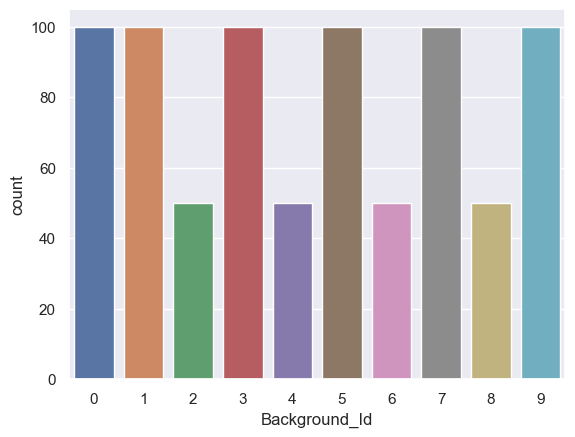

In [14]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="Background_Id", data=imagedf)
plt.show(ax)

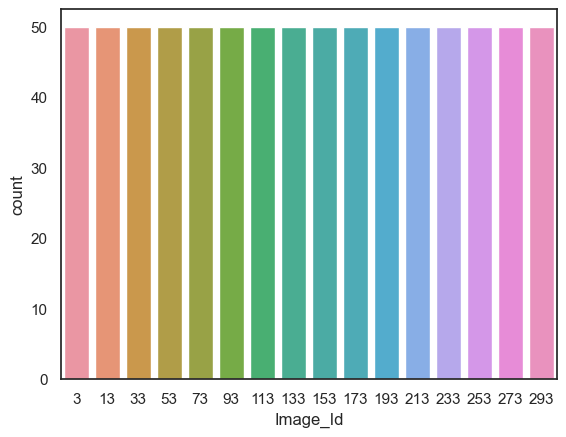

In [78]:
ax = sns.countplot(x="Image_Id", data=imagedf)
plt.show(ax)

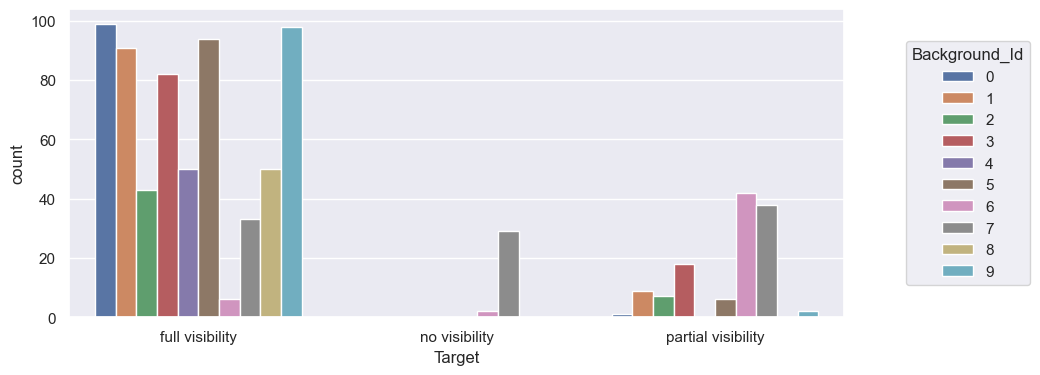

In [15]:
plt.figure(figsize=(10, 4))
plot = sns.countplot(x="Target", hue="Background_Id", data=imagedf, dodge = True)
plot.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1, title="Background_Id")
labels=['full visibility', 'no visibility', 'partial visibility']
plot.xaxis.set_ticklabels(labels)
plt.show(plot)

##### Because each id has 16 distinct photos, the collection already provides some form of 'embedded' augmentation. Because of this,

##### * I'll utilise tiny parameters for rotation and horizonal, vertical shift when applying augmentation to ensure we don't modify the target class; 
##### * for this exercise, we'll ignore the metadata's information, expecting the network would learn the feature (i.e. the backdrop) on its own.

##### So I add backdrop and card id to a separate input channel as a potential upgrade to the model.

### Let's check the images eventually.

In [16]:
import skimage
from scipy import ndimage
from skimage import exposure, color
from skimage.transform import resize
sns.set(style="white")
img_dir = "D:/aalink/images/"
img = plt.imread(os.path.join(img_dir, imagedf.Image_filename[0]))
grayscale_img1 = color.rgb2gray(img)

def plot_img1_vs_img2(img1, img2, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    ax = axes.ravel()
    ax[0].imshow(img1, cmap=plt.cm.gray)
    ax[0].set_title(title1)
    ax[1].imshow(img2, cmap=plt.cm.gray)
    ax[1].set_title(title2)

    fig.tight_layout()
    plt.show()

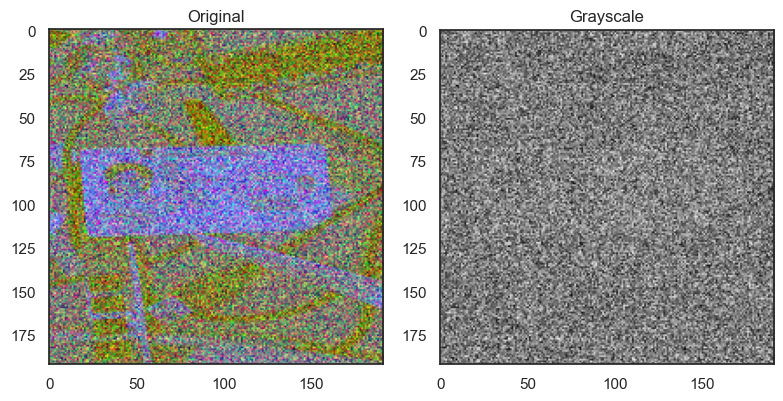

In [17]:
plot_img1_vs_img2(img, grayscale_img1, "Original", "Grayscale")

##### This does not look right, the result is simply white noise. Let's look at each channel separately to see if we can spot anything interesting

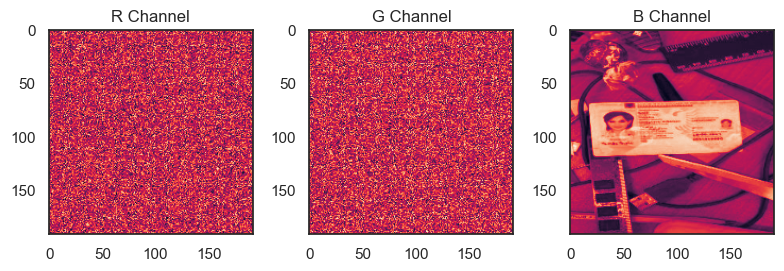

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(img[:,:,0])
ax[0].set_title("R Channel")
ax[1].imshow(img[:,:,1])
ax[1].set_title("G Channel")
ax[2].imshow(img[:,:,2])
ax[2].set_title("B Channel")

fig.tight_layout()
plt.show()

##### Now The picture in the B channel is seen below. In a grayscale colour scheme, it looks better.

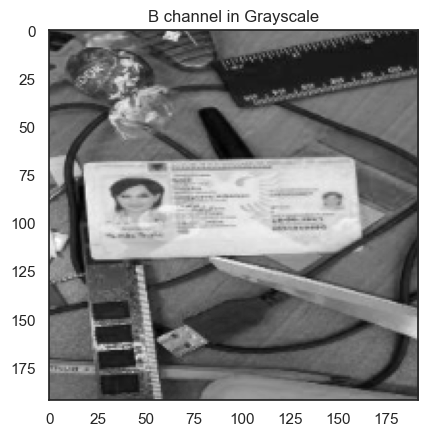

In [19]:
plt.imshow(img[:,:,2], cmap=plt.cm.gray)
plt.title("B channel in Grayscale")
plt.show()

##### I adopt the following simple assumption to determine if the real picture is always encoded in the B channel:

##### In the channel having structured information, the median (absolute) correlation among the rows in the picture matrix will be highest.
##### The median absolute correlation among the rows in the picture matrix should be minimal if a channel simply includes random pixels. When a channel encodes a genuine image, on the other hand, we may anticipate the existence of structured information to boost the mean absolute correlation.

##### This heuristic may be used to determine which channels contain the picture we need to categorise.

In [20]:
from collections import Counter
result = []
for id in range(imagedf.Image_filename.shape[0]):
    img = plt.imread(os.path.join(img_dir, imagedf.Image_filename[id]))
    median_channel_corr = {'R': abs(np.median(np.corrcoef(img[:,:,0]))), 'G': abs(np.median(np.corrcoef(img[:,:,1]))), 'B': abs(np.median(np.corrcoef(img[:,:,2])))}
    result.append(max(median_channel_corr.keys(), key=(lambda key: median_channel_corr[key])))
    if result[id] != 'B': 
        logger.info("max correlation for img %d is not for channel 'B'", id)

logger.info("count of images detected per channel: %s", Counter(result))

[INFO] 2022-02-12 08:22:42,680: max correlation for img 157 is not for channel 'B'
[INFO] 2022-02-12 08:22:46,431: max correlation for img 293 is not for channel 'B'
[INFO] 2022-02-12 08:22:48,482: max correlation for img 369 is not for channel 'B'
[INFO] 2022-02-12 08:22:50,228: max correlation for img 433 is not for channel 'B'
[INFO] 2022-02-12 08:22:57,949: count of images detected per channel: Counter({'B': 796, 'R': 3, 'G': 1})


##### Only 4 of the 800 photos had an axe median correlation in a channel other than B. However, a visual examination of these four pictures reveals that the important information is also stored in the B channel.

##### Assume the following: Given that all relevant information for all photos in the dataset has been discovered in channel B:
##### Only on channel B will images in the production setup carry valuable information.

In [21]:
def to_one_channel(img):
    return img[:,:,2]

##### Before proceeding to model training let's explore some methods that could aid in image recognition using Histogram equalization and Adaptive histogram equalization


In [22]:
def contrast(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

def HE(img):
    img_eq = exposure.equalize_hist(img)
    return img_eq

def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

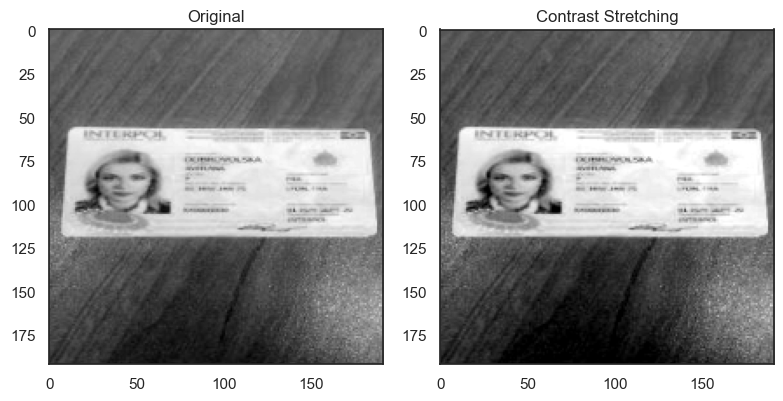

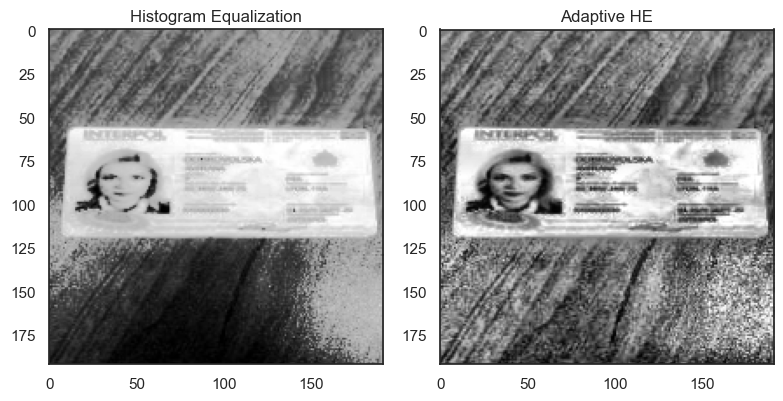

In [23]:
img_cs = contrast(to_one_channel(img))
img_he = HE(to_one_channel(img))
img_ahe = AHE(to_one_channel(img))
plot_img1_vs_img2(to_one_channel(img), img_cs, "Original", "Contrast Stretching")
plot_img1_vs_img2(img_he, img_ahe, "Histogram Equalization", "Adaptive HE")

Looking at the transformations above, it's clear that contrast stretching improves the distinction between the backdrop and the ID card over the original picture, and it doesn't distort the information on the ID as Histogram Equalization(HE) and Adaptive HE do. As a result, it appears to be a useful strategy to use in picture preparation.

### Splitting Data Into Train and Test

##### Now it's time to split the data into training and testing set. It is important to balance the split with regards to our target column.

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(imagedf.Image_filename, imagedf.Target, test_size=0.30, random_state=0, shuffle=True, stratify=imagedf['Target'])

##### Because there is a significant class imbalance in the training set, oversampling of minority classes (NO VISIBILITY and PARTIAL VISIBILITY) is used to balance the classes.

In [25]:
df_train= imagedf.loc[x_train.index.tolist()]
df_train.shape

(560, 6)

#### Oversample the minority classes to match the majority class.
#####    * :param df: pandas dataframe - input df.
#####    * :param target: string - classification target column.
#####    * :return: pandas datframe - oversampled version

In [26]:
def _oversample_positives(df, target):
    class_count = df[target].value_counts()
    print("Before oversampling: %s" % class_count)
    for i in range(1,len(class_count)):
        df_i = df[df[target] == i]
        oversampling_factor_i = class_count[0] / float(class_count[i])
        print(len(df_i))
        print("Oversampling factor for class %i: %s" %(i, str(oversampling_factor_i)))
        df = df.append(
            [df_i] * int(math.floor(oversampling_factor_i) - 1),
            ignore_index=False)
        df = df.append(
            [df_i.sample(frac=oversampling_factor_i % 1)],
            ignore_index=False)
    
    print("After oversampling: %s" % df[target].value_counts())
    print("Shape after oversampling: %s" % str(df.shape))
    return df

In [27]:
df_train_oversampled = _oversample_positives(df_train, "Target")

Before oversampling: 0    452
2     86
1     22
Name: Target, dtype: int64
22
Oversampling factor for class 1: 20.545454545454547
86
Oversampling factor for class 2: 5.255813953488372
After oversampling: 0    452
1    452
2    452
Name: Target, dtype: int64
Shape after oversampling: (1356, 6)


In [28]:
x_train_oversampled = df_train_oversampled["Image_filename"]
y_train_oversampled = df_train_oversampled["Target"]

### Create CNN Model 

As a quick baseline I have used multilogit regression without any extra transformations on the images, which yilded AUC of 0.63 on the training set, further oversampling and augmentation didn't raise the score much higher.

The main approach to modelling would be to use a Convolutional Neural Network which can extract regional information and is much more robust to vatiations in the images. Given the time limitations of the task, relativly small amoung of images we have (only 800 images in total of which 600 fall into training set) and strong variations in the background that is not evenly distributed among target classes, the best course of action would be to apply transfer learning so that the network can build on the already tained layers that recognize shapes, testures and forms. As a backbone I used CNN Network Model using Tensorflow  which provides a deeper network at smaller computational expense by introducing skip connections which also mitigate the problem of vanishing gradient.

The backbone is followed by  Dense layers with dropout for regularization and an output layer with softmax activation.

Loss: Categorical cross entropy

In [29]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
import tensorflow as tf

def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation = 'relu', padding = 'same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation = 'relu'))
        model.add(MaxPooling2D(pool_size = 2))
        model.add(Dropout(0.5))
        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape = (192, 192, 3))) 

    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    model = add_conv_block(model, 256)

    model.add(Flatten())
    model.add(Dense(3, activation = 'softmax'))

    model.compile(
        loss='categorical_crossentropy', 
        optimizer = 'adam', 
        metrics = ['accuracy']
        )

    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 190, 190, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 95, 95, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 95, 95, 64)        2

In [30]:
X_train_images = []
for file in x_train_oversampled:
    train_img = to_one_channel(plt.imread(os.path.join(img_dir, file)))
    train_img = np.stack((train_img,)*3, axis=-1)
    train_img = contrast(train_img)
    X_train_images.append(train_img)
X_train_images = np.array(X_train_images)

In [31]:
X_train_images.shape

(1356, 192, 192, 3)

In [32]:
from keras.utils import to_categorical
y_train_binary = to_categorical(y_train_oversampled)

In [33]:
X_test_images = []
for file in x_test:
    test_img = to_one_channel(plt.imread(os.path.join(img_dir, file)))
    test_img = np.stack((test_img,)*3, axis=-1)
    test_img = contrast(test_img)
    X_test_images.append(test_img)
X_test_images = np.array(X_test_images)

In [ ]:
from keras.utils import to_categorical
y_train_binary = to_categorical(y_train_oversampled)

In [34]:
from keras.preprocessing.image import ImageDataGenerator
Imagedata = ImageDataGenerator(
    rotation_range=4,
    width_shift_range=[-2, 2],
    height_shift_range=[-5, 5])

In [35]:
model.fit_generator(Imagedata.flow(X_train_images, y_train_binary, batch_size=32), verbose = 1, epochs=35, shuffle=True)

[WARNING] 2022-02-12 08:23:18,984: From <ipython-input-35-9d5161f1e60e>:1: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/35
43/43 [==============================] - 153s 4s/step - loss: 4.0538 - accuracy: 0.5760
Epoch 2/35
43/43 [==============================] - 149s 3s/step - loss: 1.4091 - accuracy: 0.6777
Epoch 3/35
43/43 [==============================] - 146s 3s/step - loss: 1.1411 - accuracy: 0.7434
Epoch 4/35
43/43 [==============================] - 146s 3s/step - loss: 1.0500 - accuracy: 0.7522
Epoch 5/35
43/43 [==============================] - 146s 3s/step - loss: 0.7348 - accuracy: 0.8053
Epoch 6/35
43/43 [==============================] - 147s 3s/step - loss: 0.4741 - accuracy: 0.8709
Epoch 7/35
43/43 [==============================] - 148s 3s/step - loss: 0.4076 - accuracy: 0.8754
Epoch 8/35
43/43 [==============================] - 148s 3s/step - loss: 0.3627 - accuracy: 0.8805
Epoch 9/35
43/43 [==============================] - 147s 3s/step - loss: 0.2817 - accuracy: 0.9093
Epoch 10/35
43/43 [==============================] - 148s 3s/step - loss: 0.2798 - accuracy: 0.9152
Epoch 11/

In [36]:
predictions = model.predict(X_test_images)

In [40]:
print("Predicted results:",predictions[0:5])

Predicted results: [[9.79456246e-01 1.04922583e-06 2.05426551e-02]
 [1.20505993e-03 1.16490613e-04 9.98678386e-01]
 [1.20356336e-01 5.96456230e-03 8.73679101e-01]
 [9.99998808e-01 7.56690378e-14 1.23395057e-06]
 [9.99386907e-01 7.38570316e-09 6.13065960e-04]]


#### Converting predictions to a single number

In [45]:
predictions_num = np.argmax(predictions, axis=1)
predictions_num

array([0, 2, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2,
       0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 1, 0, 2, 0, 0, 0,
       2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0,
       0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2,
       2, 0, 2, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 2, 2,
       2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2],
      dtype=int64)

In [48]:
class_map = {0:"FULL_VISIBILITY", 1:"NO_VISIBILITY", 2:"PARTIAL_VISIBILITY"}
class_map[predictions_num[0]]

'FULL_VISIBILITY'

#### Evaluation : Check AUC of the model


In [80]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_num, pos_label=2)
auccuracy = metrics.auc(fpr, tpr)
f1_score = metrics.f1_score(y_true = y_test, y_pred = predictions_num, average=None)
f1_score_weighted = metrics.f1_score(y_true = y_test, y_pred = predictions_num, average='weighted')
print("auc = %f" % auccuracy)
print("f1_score_weighted = %s" % f1_score_weighted)
print("f1_score = %s" % f1_score)

auc = 0.995074
f1_score_weighted = 0.9917547268430144
f1_score = [0.99481865 1.         0.97368421]


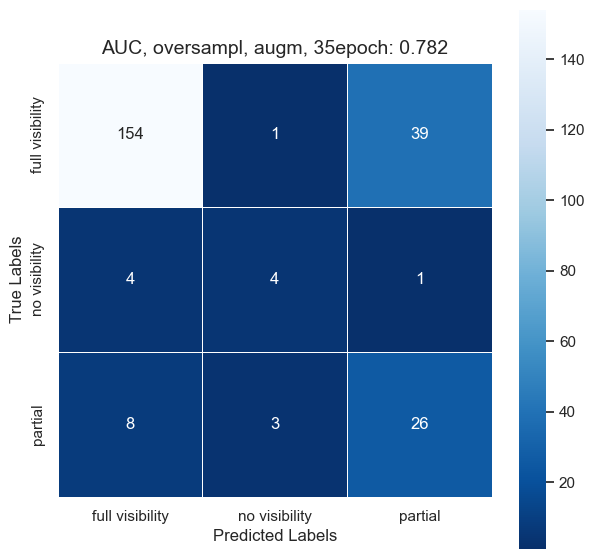

In [54]:
cm = metrics.confusion_matrix(y_test, predictions_num)
plt.figure(figsize=(7,7))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r'); 
ax.set_xlabel('Predicted Labels', size=12);
ax.set_ylabel('True Labels', size=12); 
ax.set_title('AUC, oversampl, augm, 35epoch: {:.3f}'.format(auc), size=14); 
ticklabels=['full visibility', 'no visibility', 'partial']
ax.xaxis.set_ticklabels(ticklabels); 
ax.yaxis.set_ticklabels(ticklabels);
plt.show(ax)

#### The model has a high level of confidence in its predictions.

### Production Model : (trained on all data)

In [56]:
df_prod_oversampled = _oversample_positives(imagedf, "Target")
x_prod_oversampled = df_prod_oversampled["Image_filename"]
y_prod_oversampled = df_prod_oversampled["Target"]

Before oversampling: 0    646
2    123
1     31
Name: Target, dtype: int64
31
Oversampling factor for class 1: 20.838709677419356
123
Oversampling factor for class 2: 5.252032520325203
After oversampling: 0    646
1    646
2    646
Name: Target, dtype: int64
Shape after oversampling: (1938, 6)


In [58]:
X_prod_images = []
for file in x_prod_oversampled:
    prod_img = to_one_channel(plt.imread(os.path.join(img_dir, file)))
    prod_img = np.stack((prod_img,)*3, axis=-1)
    prod_img = contrast(prod_img)
    X_prod_images.append(prod_img)
X_prod_images = np.array(X_prod_images)

In [63]:
X_test_prod_images = []
for file in x_test:
    test_prod_img = to_one_channel(plt.imread(os.path.join(img_dir, file)))
    test_prod_img = np.stack((test_prod_img,)*3, axis=-1)
    test_prod_img = contrast(test_prod_img)
    X_test_prod_images.append(test_prod_img)
X_test_prod_images = np.array(X_test_prod_images)

In [59]:
y_prod_binary = to_categorical(y_prod_oversampled)

In [61]:
model.fit_generator(Imagedata.flow(X_prod_images, y_prod_binary, batch_size=32), verbose = 1, epochs=35, shuffle=True)

Epoch 1/35
61/61 [==============================] - 223s 4s/step - loss: 0.4021 - accuracy: 0.9040
Epoch 2/35
61/61 [==============================] - 229s 4s/step - loss: 0.2465 - accuracy: 0.9293
Epoch 3/35
61/61 [==============================] - 230s 4s/step - loss: 0.1769 - accuracy: 0.9396
Epoch 4/35
61/61 [==============================] - 237s 4s/step - loss: 0.1339 - accuracy: 0.9546
Epoch 5/35
61/61 [==============================] - 251s 4s/step - loss: 0.1456 - accuracy: 0.9556
Epoch 6/35
61/61 [==============================] - 246s 4s/step - loss: 0.1413 - accuracy: 0.9556
Epoch 7/35
61/61 [==============================] - 248s 4s/step - loss: 0.1175 - accuracy: 0.9680
Epoch 8/35
61/61 [==============================] - 258s 4s/step - loss: 0.0970 - accuracy: 0.9706
Epoch 9/35
61/61 [==============================] - 255s 4s/step - loss: 0.1358 - accuracy: 0.9644
Epoch 10/35
61/61 [==============================] - 261s 4s/step - loss: 0.1863 - accuracy: 0.9587
Epoch 11/

In [64]:
predictions = model.predict(X_test_prod_images)

In [65]:
print("Predicted results:",predictions[0:5])

Predicted results: [[1.0000000e+00 6.5497161e-14 8.1638424e-10]
 [9.9204224e-01 2.6022269e-06 7.9551032e-03]
 [1.0000000e+00 9.4409574e-20 2.1115881e-15]
 [9.9999988e-01 2.9336483e-10 5.9631240e-08]
 [1.0000000e+00 7.6553630e-18 4.3380702e-16]]


In [66]:
predictions_num = np.argmax(predictions, axis=1)
predictions_num

array([0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0,
       2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [67]:
class_map = {0:"FULL_VISIBILITY", 1:"NO_VISIBILITY", 2:"PARTIAL_VISIBILITY"}
class_map[predictions_num[0]]

'FULL_VISIBILITY'

In [68]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_num, pos_label=2)
auccuracy = metrics.auc(fpr, tpr)
f1_score = metrics.f1_score(y_true = y_test, y_pred = predictions_num, average=None)
f1_score_weighted = metrics.f1_score(y_true = y_test, y_pred = predictions_num, average='weighted')
print("auc = %f" % auccuracy)
print("f1_score_weighted = %s" % f1_score_weighted)
print("f1_score = %s" % f1_score)

auc = 0.995074
f1_score_weighted = 0.9917547268430144
f1_score = [0.99481865 1.         0.97368421]


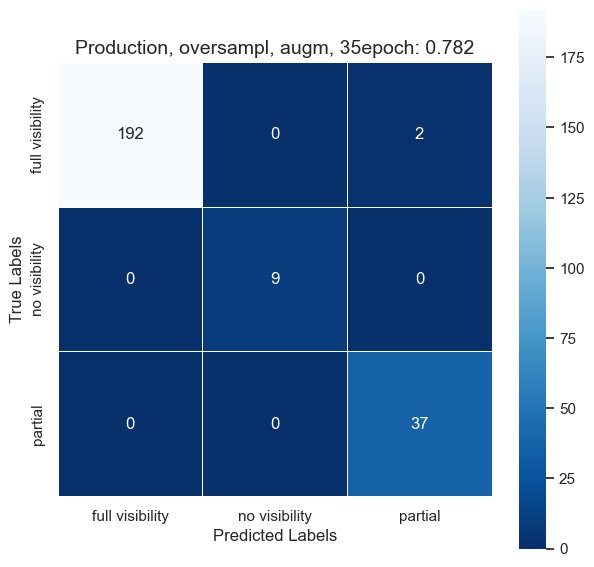

In [81]:
cm = metrics.confusion_matrix(y_test, predictions_num)
plt.figure(figsize=(7,7))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
ax.set_xlabel('Predicted Labels', size=12);
ax.set_ylabel('True Labels', size=12); 
ax.set_title('Production, oversampl, augm, 35epoch: {:.3f}'.format(auc), size=14); 
ticklabels=['full visibility', 'no visibility', 'partial']
ax.xaxis.set_ticklabels(ticklabels); 
ax.yaxis.set_ticklabels(ticklabels);
plt.show(ax)

#### The model has a high level of confidence in its predictions better than AUC of the Model.

### Saving the CNN Model to model hdf5 file

In [72]:
model.save('D:/aalink/CNN_model/prod_CNN_oversampling_model.h5')  